In [4]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from transformers import BertModel, BertTokenizer
import torch
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import regex as re
from nltk.stem import WordNetLemmatizer

c:\Users\prath\anaconda3\envs\FADS_ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Preparation

In [5]:
# Load multiple Excel sheets into a single DataFrame
uncat_df = pd.read_excel("full_dataset.xlsx", sheet_name=None)
df = pd.concat(uncat_df.values(), ignore_index=True)

In [6]:
# Remove auto-generated columns that are not relevant to the analysis
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop any rows with missing values to maintain data quality and consistency
df = df.dropna()

## Text Preprocessing

In [7]:
# Initialize the lemmatizer to standardize forms of words in the text
lemmatizer = WordNetLemmatizer()

In [8]:
def identify_low_value_words(texts, min_freq=5, max_length=5):
    """
    Function: identify_low_value_words
    Purpose: Identifies words that do not contribute significantly to text analysis.
        - 'texts': list of all text entries
        - 'min_freq': minimum frequency threshold for word inclusion
        - 'max_length': maximum length threshold for word inclusion
    Returns: A set of words considered to be of low value based on frequency and length criteria.
    """
    
    all_words = " ".join(texts).split()
    word_counts = Counter(all_words)
    return {
        word for word, count in word_counts.items()
        if count <= min_freq or len(word) <= max_length
    }

In [9]:
def preprocess(text):
    """
    Function: preprocess
    Purpose: Cleans and prepares text data for analysis by removing stopwords, punctuation, low value words and applying lemmatization.
        - 'text': a single text entry
    Returns: A cleaned and preprocessed string of text.
    """

    # Custom stopwords relevant to the dataset's context
    cust_stop_words = {
        'work', 'insight', 'design', 'space', 'workplace', 'experience', 
        'gensler', 'hks', 'corgan', 'dlr', 'hok', 'interior', 'nelson',
        'perkins', 'will', 'eastman', 'perkin', 'people', 'project',
        'said', 'would', 'always', 'like', 'im', 'one', 'ive', 'think', 'thing'
    }
    # Combine with NLTK's comprehensive list of English stopwords
    stop_words = set(stopwords.words('english'))
    # Regular expression pattern to remove all punctuation
    punctuation_pattern = r'[^\w\s]'
    text = re.sub(punctuation_pattern, '', text)
    tokens = word_tokenize(text)
    low_value_words = identify_low_value_words(df['Abstract'].tolist())

    return " ".join([
        lemmatizer.lemmatize(token.lower())
        for token in tokens
        if token.lower() not in stop_words and
        token.lower() not in cust_stop_words and
        token.lower() not in low_value_words
    ])


In [10]:
# Apply the preprocessing function to all abstracts in the dataset
df['text'] = df['Abstract'].apply(preprocess)

In [11]:
# Extract firm names from article numbers using a consistent identifier format
company_name = []
for article_number in df['Article Number'].values.tolist():
    name = article_number.split('_')[0].lower()
    company_name.append(name)

df['Company_names'] = company_name

## Finding Unique Words

In [19]:
str_text = "".join(df.text.values.tolist())

print(len(set(str_text.split(" "))))

12832


## Topic Modeling with NMF (Non-negative Matrix Factorization)

In [10]:
# Configure TF-IDF Vectorizer to convert text data into a format suitable for topic modeling
vectorizer = TfidfVectorizer(
    max_df=0.7,  # Ignore terms with a document frequency strictly higher than the given threshold
    min_df=3,    # Ignore terms with a document frequency strictly lower than the given threshold
    max_features=2000,  # The maximum number of features (dimensions) to extract
    ngram_range=(1, 3)  # Consider range of n-grams to consider
)

# Apply the vectorizer to the preprocessed text data
tfidf = vectorizer.fit_transform(df['text'])

In [11]:
# Initialize the NMF model with 7 components as an arbitrary choice for topic number
nmf = NMF(n_components=7, random_state=420, l1_ratio=0.5, init='nndsvda')
nmf_output = nmf.fit_transform(tfidf)

In [12]:
# Normalize the NMF output to ensure each feature vector has a unit norm
nmf_output = Normalizer().fit_transform(nmf_output)
df['Topic'] = nmf_output.argmax(axis=1)

In [13]:
# Count the distribution of documents over each topic
print(df['Topic'].value_counts())

Topic
3    121
5    113
2    103
1     67
0     53
6     51
4     42
Name: count, dtype: int64


c:\Users\prath\anaconda3\envs\FADS_ENV\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


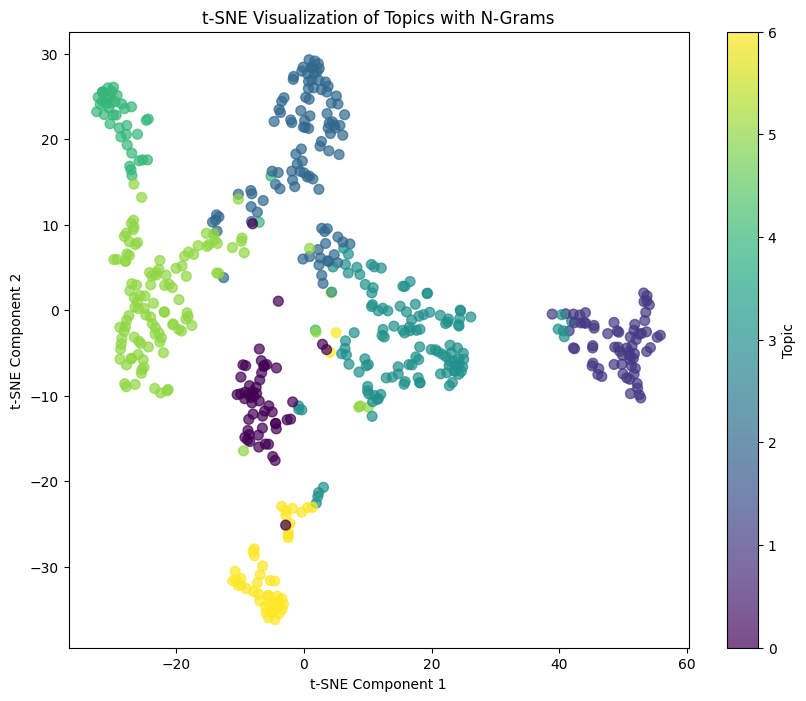

In [14]:
# Visualize document clusters with t-SNE, a tool to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=420, perplexity=20, n_iter=1000)
tsne_embedding = tsne.fit_transform(nmf_output)
df['tsne-2d-one'] = tsne_embedding[:, 0]
df['tsne-2d-two'] = tsne_embedding[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(df['tsne-2d-one'], df['tsne-2d-two'], c=df['Topic'], cmap='viridis', s=50, alpha=0.7)
plt.title('t-SNE Visualization of Topics with N-Grams')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Topic')
plt.show()

## Merging Specific Terms

In [15]:
def merge_healthcare_terms(text):
    """
    Function: merge_healthcare_terms
    Purpose: Merges separate occurrences of 'health' and 'care' into a single term 'healthcare' within text.
        - 'text': the input text where merging should be applied.
    Returns: Modified text with 'health' and 'care' merged into 'healthcare'.
    """
    # Merge 'health' and 'care' if they appear together, respecting case insensitivity
    merged_text = re.sub(r'\bhealth\b\s*\bcare\b', 'healthcare', text, flags=re.IGNORECASE)
    # Replace individual occurrences of 'health' or 'care' with 'healthcare'
    merged_text = re.sub(r'\bhealth\b|\bcare\b', 'healthcare', merged_text, flags=re.IGNORECASE)
    return merged_text

## Adjusting Topic Weights for Better Interpretation

In [16]:
def merge_healthcare_weights(components, feature_names):
    """
    Function: merge_healthcare_weights
    Purpose: Combines the weights of terms 'health' and 'care' into 'healthcare' in the NMF component matrix.
        - 'components': the NMF component matrix where each row corresponds to a topic.
        - 'feature_names': the names of features/terms in the NMF model.
    Returns: A dictionary with adjusted term weights where 'health' and 'care' are merged.
    """
    merged_weights = {}
    # Sum weights of 'health' and 'care' into 'healthcare'
    for idx, word in enumerate(feature_names):
        if word in ['health', 'care']:
            merged_weights['healthcare'] = merged_weights.get('healthcare', 0) + components[idx]
        else:
            merged_weights[word] = components[idx]
    return merged_weights

## Word Cloud Generation

In [17]:
def generate_weighted_wordcloud(topic_idx):
    """
    Function: generate_weighted_wordcloud
    Purpose: Generates a word cloud for a specific topic using weighted terms from NMF components.
        - 'topic_idx': index of the topic for which the word cloud is generated.
    Returns: A WordCloud object representing the topic.
    """
    # Merge healthcare-related terms weights for the topic
    merged_weights = merge_healthcare_weights(nmf.components_[topic_idx], vectorizer.get_feature_names_out())
    # Create a word cloud from the merged frequencies
    wordcloud = WordCloud(
        width=800, height=800, background_color='white', colormap='tab10',
        max_words=120, contour_width=2, contour_color='black'
    ).generate_from_frequencies(merged_weights)
    return wordcloud

## Plotting Word Clouds for Each Topic

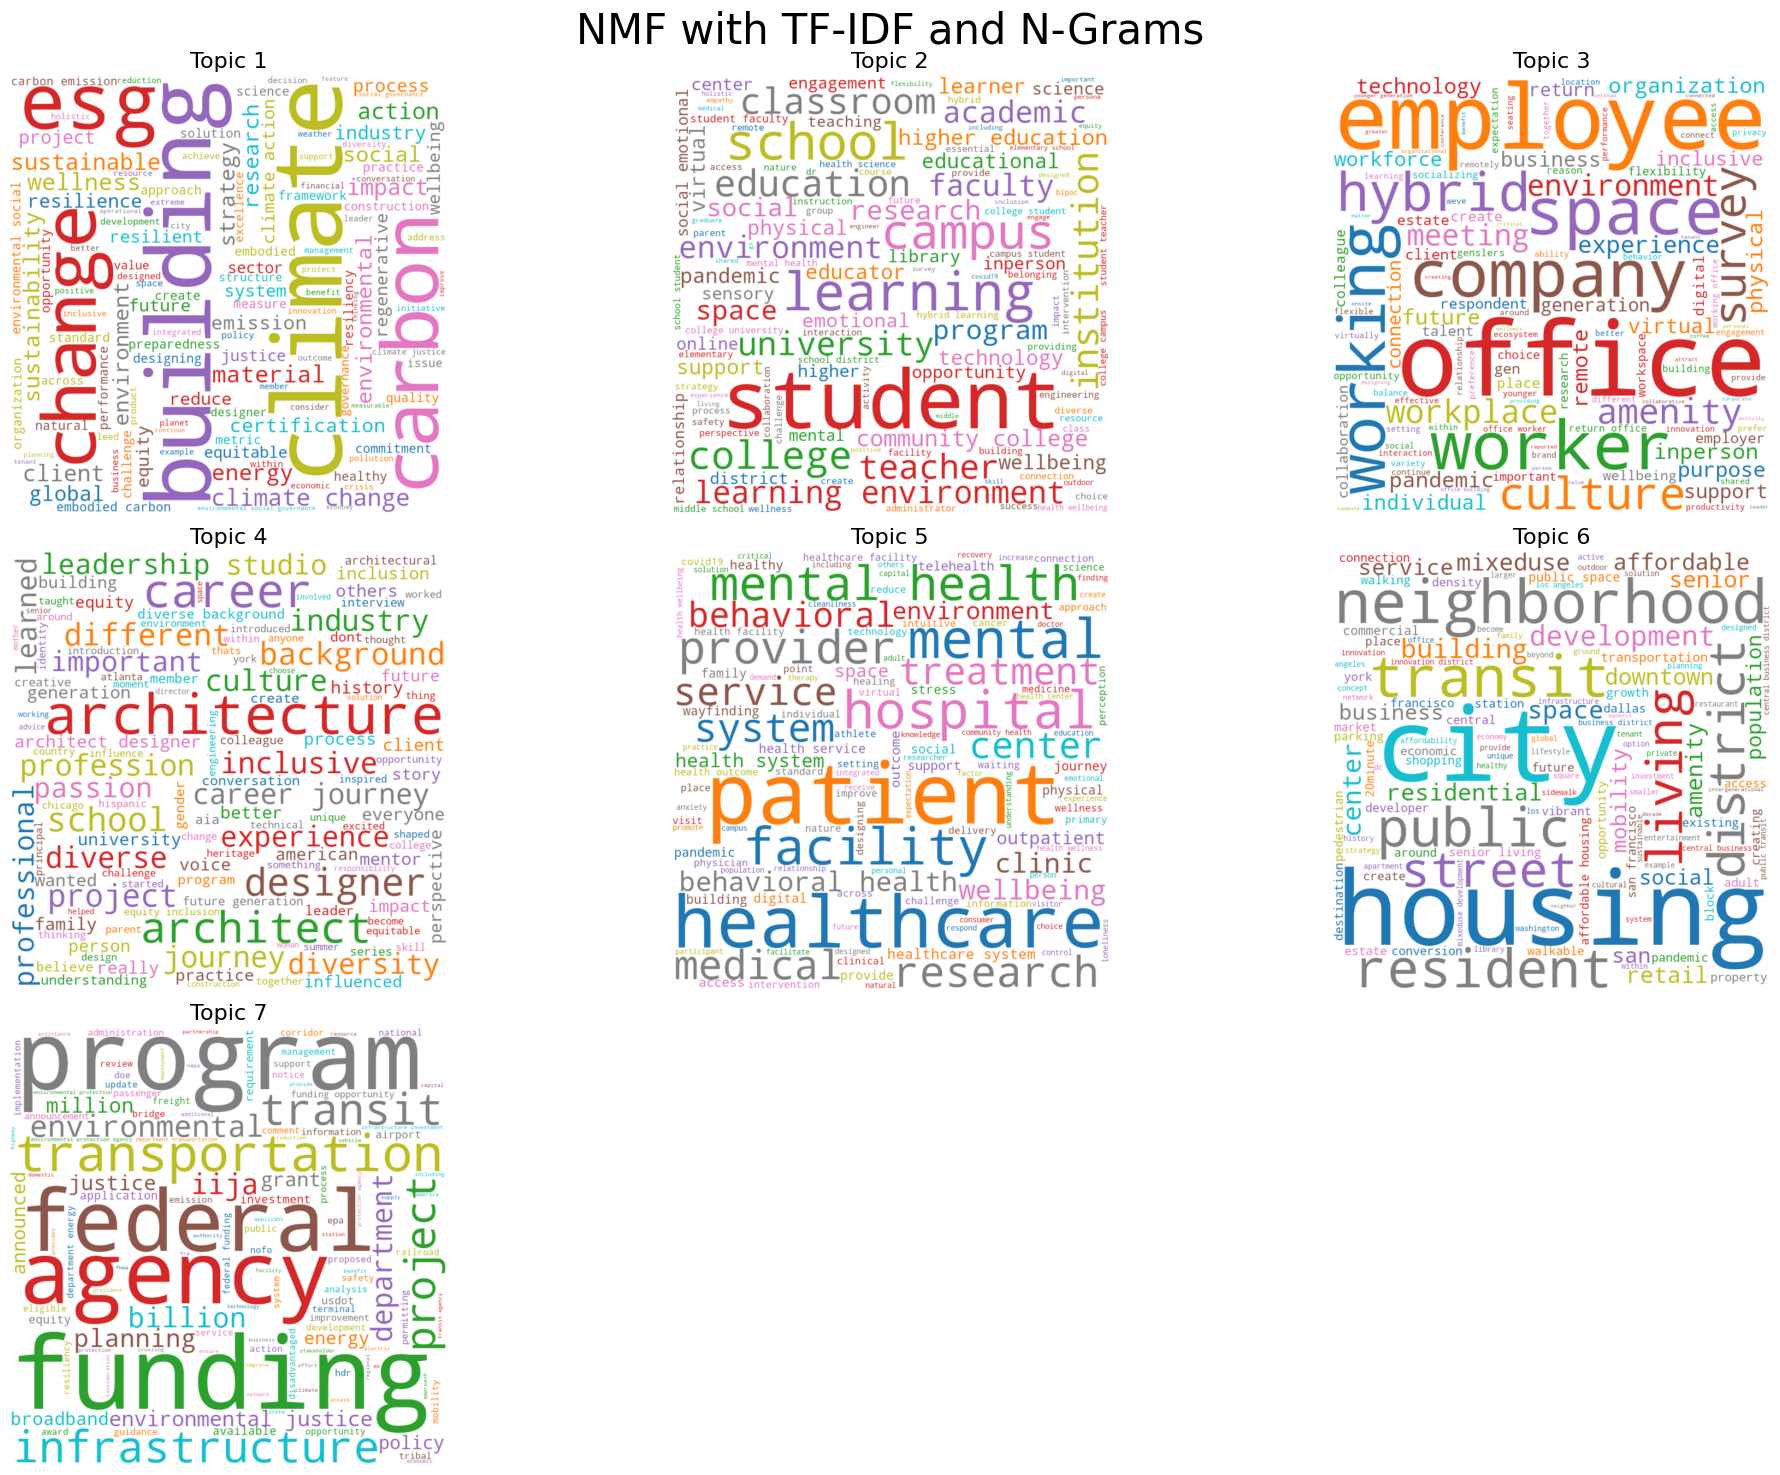

In [18]:
# Determine the number of topics and the layout for plotting
num_topics = len(df['Topic'].unique())
rows = (num_topics + 2) // 3

# Create subplot layout
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))
axes = axes.flatten()
fig.suptitle('NMF with TF-IDF and N-Grams', fontsize=30)

# Plot word clouds for each topic
for idx in range(num_topics):
    wordcloud = generate_weighted_wordcloud(idx)
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'Topic {idx + 1}', fontsize=16)

# Remove any unused axes
for i in range(num_topics, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('wordcloud.jpeg', format='jpeg', dpi=300)

plt.show()

In [19]:
# Mapping abbreviations to full names to enhance clarity in visualizations
firm_name_mapping = {
    'gensler': 'Gensler',
    'hks': 'HKS',
    'hdr': 'HDR',
    'pe': 'Perkins Eastman',
    'dlr': 'DLR',
    'corgan': 'Corgan',
    'ia': 'IA Interior Architects',
    'pw': 'Perkins&Will'
}

## Analysis of Article Counts by Year and Firm

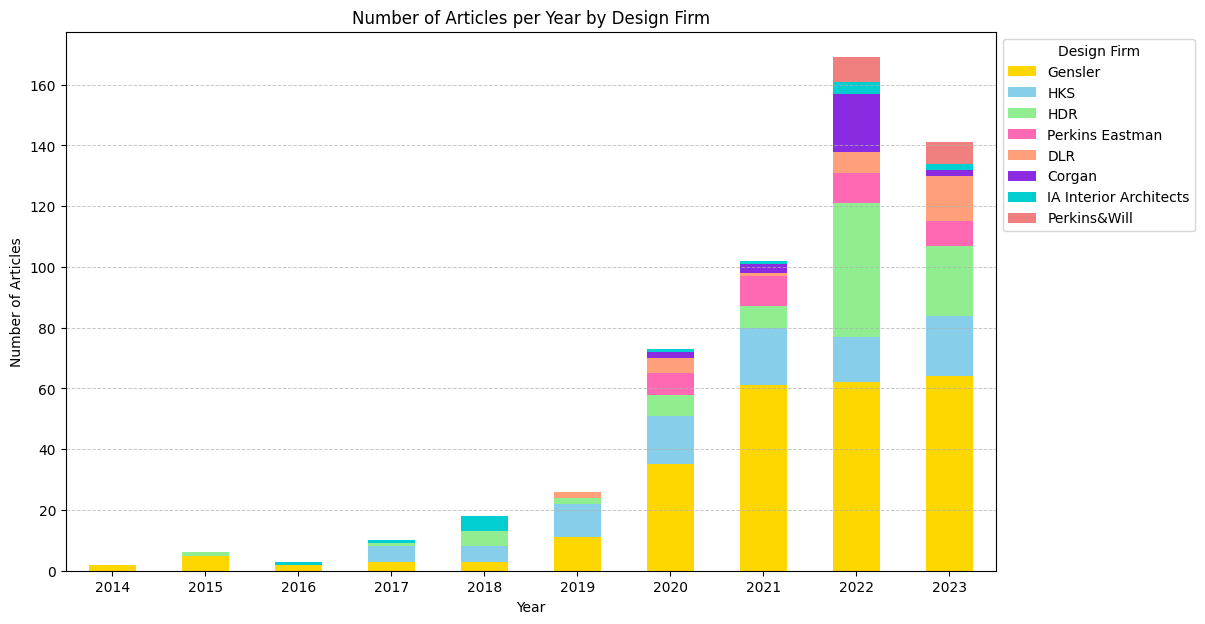

In [90]:
import matplotlib.pyplot as plt

# Mapping short forms to full names
firm_name_mapping = {
    'gensler': 'Gensler',
    'hks': 'HKS',
    'hdr': 'HDR',
    'pe': 'Perkins Eastman',
    'dlr': 'DLR',
    'corgan': 'Corgan',
    'ia': 'IA Interior Architects',
    'pw': 'Perkins&Will'
}

# Grouping articles by year and firm
article_counts = df.groupby(['year', 'Company_names']).size().unstack(fill_value=0)

# Calculating total contributions for each firm
total_contributions = article_counts.sum().sort_values(ascending=False)

# Reordering the DataFrame based on total contributions
article_counts = article_counts[total_contributions.index]

# Custom color palette (aligned with sorted firms)
color_palette = [
    '#FFD700',  # Gold
    '#87CEEB',  # Sky Blue
    '#90EE90',  # Light Green
    '#FF69B4',  # Hot Pink
    '#FFA07A',  # Light Salmon
    '#8A2BE2',  # Blue Violet
    '#00CED1',  # Dark Turquoise
    '#F08080',  # Light Coral
]

# Plotting the data using a stacked bar chart
ax = article_counts.plot(kind='bar', stacked=True, figsize=(12, 7), color=color_palette)

# Adding grid lines for better legibility
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Add plot titles and labels
plt.title('Number of Articles per Year by Design Firm')
plt.xlabel('Year')
plt.ylabel('Number of Articles')

# Dynamically updating the legend with full firm names
plt.legend(
    title='Design Firm',
    labels=[firm_name_mapping[firm] for firm in total_contributions.index],
    loc='upper left', bbox_to_anchor=(1, 1)  # Positioning the legend outside the plot for clarity
)

# Ensuring year labels are horizontal
plt.xticks(rotation=0)

plt.savefig('stacked_bar.jpeg', format='jpeg', dpi=300)

# Display the plot
plt.show()


## Analysis of Trend of Topic Percentage across Firms

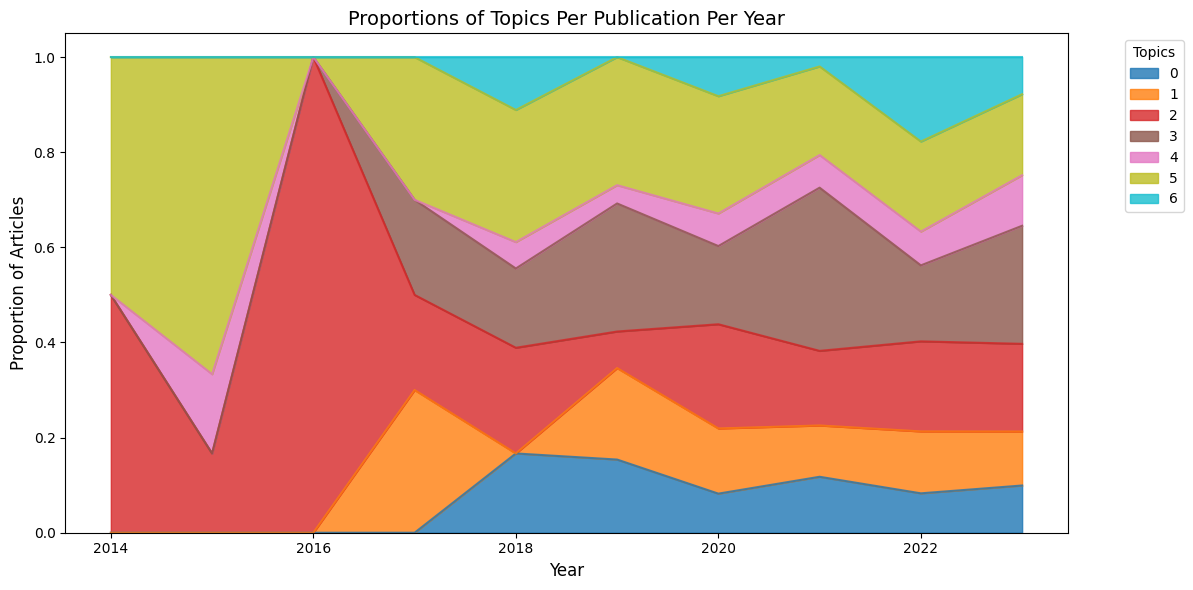

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataframe (assuming it's already loaded as 'df')
# If your data is in a CSV file, use: df = pd.read_csv('your_file.csv')

# Group by year and topic to get the count of articles per topic per year
topic_year_df = df.groupby(['year', 'Topic']).size().reset_index(name='count')

# Pivot the dataframe to get topics as columns and years as rows
topic_year_pivot = topic_year_df.pivot(index='year', columns='Topic', values='count').fillna(0)

# Normalize the data to get proportions (each row sums to 1)
topic_year_proportions = topic_year_pivot.div(topic_year_pivot.sum(axis=1), axis=0)

# Plotting the stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the stacked area chart with topics as areas
topic_year_proportions.plot.area(ax=ax, cmap='tab10', alpha=0.8)

# Adding labels and title
ax.set_title('Proportions of Topics Per Publication Per Year', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion of Articles', fontsize=12)

# Adding legend
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


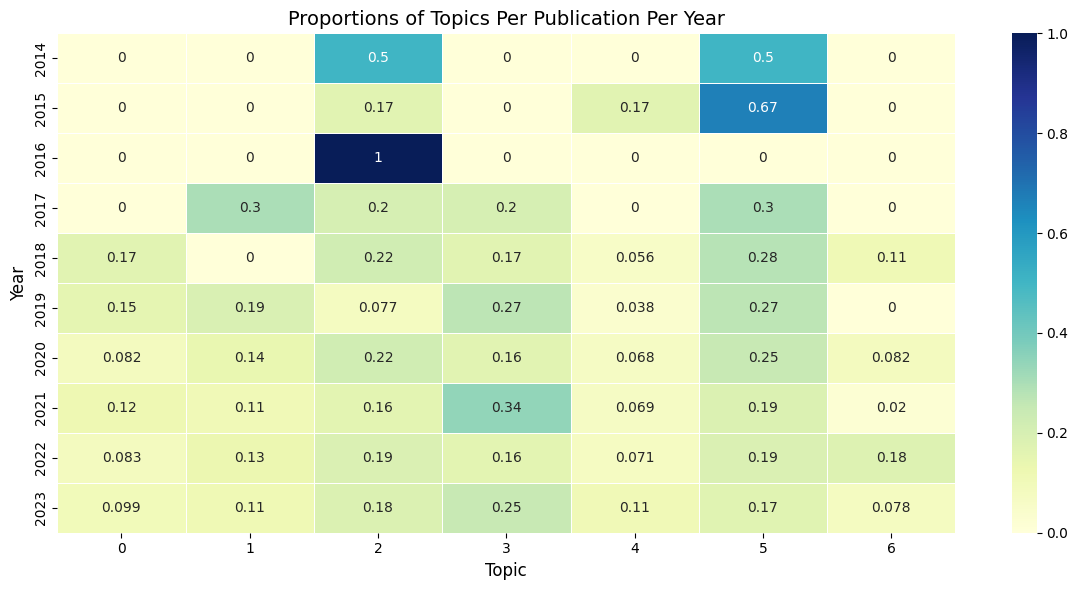

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and topic to get the count of articles per topic per year
topic_year_df = df.groupby(['year', 'Topic']).size().reset_index(name='count')

# Pivot the dataframe to get topics as columns and years as rows
topic_year_pivot = topic_year_df.pivot(index='year', columns='Topic', values='count').fillna(0)

# Normalize the data to get proportions (each row sums to 1)
topic_year_proportions = topic_year_pivot.div(topic_year_pivot.sum(axis=1), axis=0)

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(topic_year_proportions, annot=True, cmap='YlGnBu', linewidths=0.5)

# Adding labels and title
plt.title('Proportions of Topics Per Publication Per Year', fontsize=14)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Year', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Analysis of Topic trend across Firms

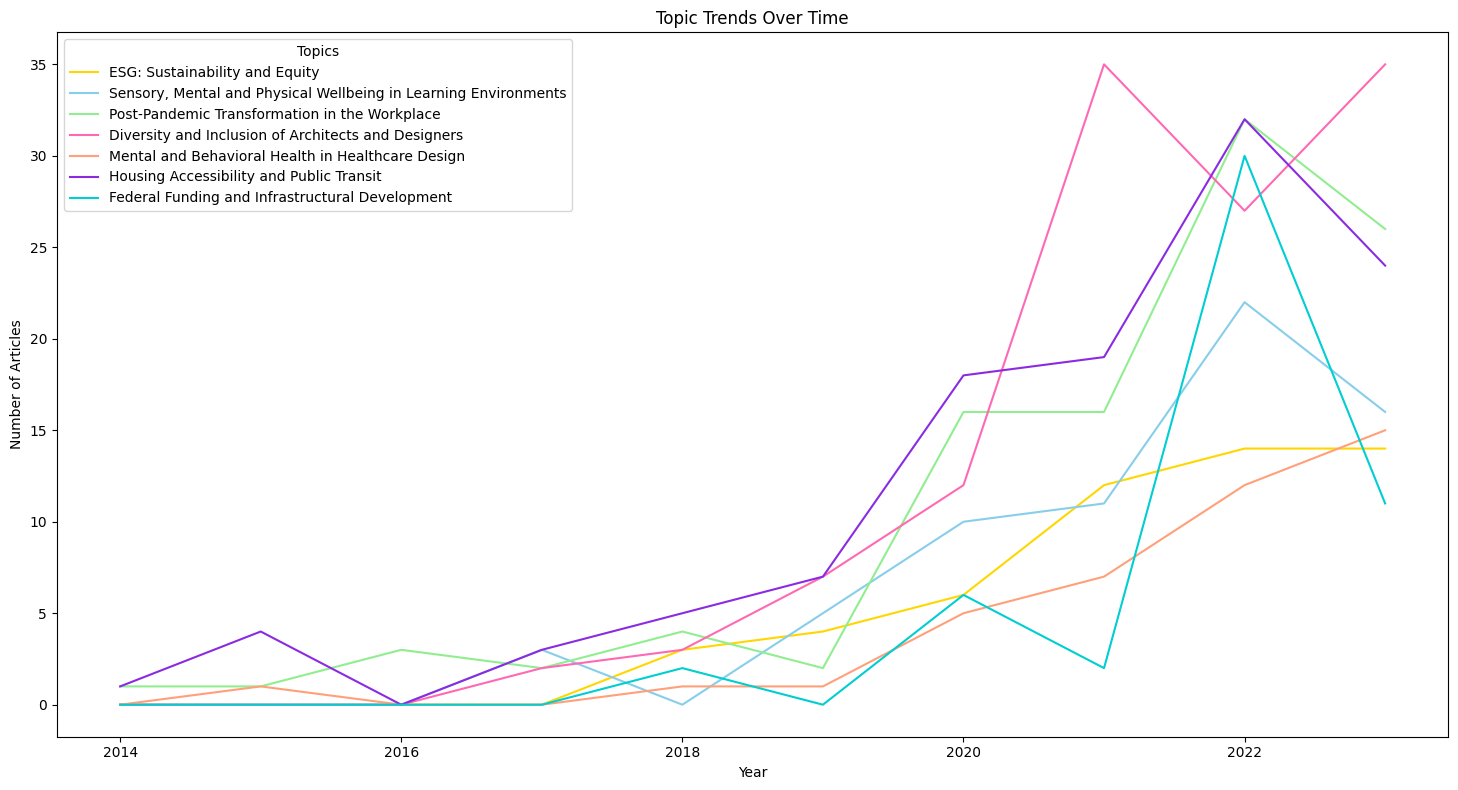

In [142]:
import matplotlib.pyplot as plt

# Define topic labels
topic_labels = {
    0: 'ESG: Sustainability and Equity',
    1: 'Sensory, Mental and Physical Wellbeing in Learning Environments',
    2: 'Post-Pandemic Transformation in the Workplace',
    3: 'Diversity and Inclusion of Architects and Designers',
    4: 'Mental and Behavioral Health in Healthcare Design',
    5: 'Housing Accessibility and Public Transit',
    6: 'Federal Funding and Infrastructural Development'
}


articles_per_year = df.groupby('year').size()

# Calculate the number of articles per topic per year
topic_counts_per_year = df.groupby(['year', 'Topic']).size().unstack(fill_value=0)

# Map the columns from numbers to topic names
topic_counts_per_year.columns = [topic_labels[x] for x in topic_counts_per_year.columns]

# Plot the number of articles per topic over time
plt.figure(figsize=(15, 8))

for i, topic in enumerate(topic_counts_per_year.columns):
    plt.plot(topic_counts_per_year.index, topic_counts_per_year[topic], label=topic, color=color_palette[i])

plt.title('Topic Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Topics', bbox_to_anchor=(.375, 1))
plt.tight_layout()

plt.savefig('trend_counts.jpeg', format='jpeg', dpi=300)
plt.show()



## Group articles by year and firm to visualize trends

In [ ]:

# Group articles by year and the company names, counting occurrences
article_counts = df.groupby(['year', 'Company_names']).size().unstack(fill_value=0)

# Calculate the total articles per firm across all years for sorting
total_contributions = article_counts.sum().sort_values(ascending=False)

# Sort the DataFrame by total contributions for consistency in visualization
article_counts = article_counts[total_contributions.index]

print(article_counts)

NameError: name 'df' is not defined

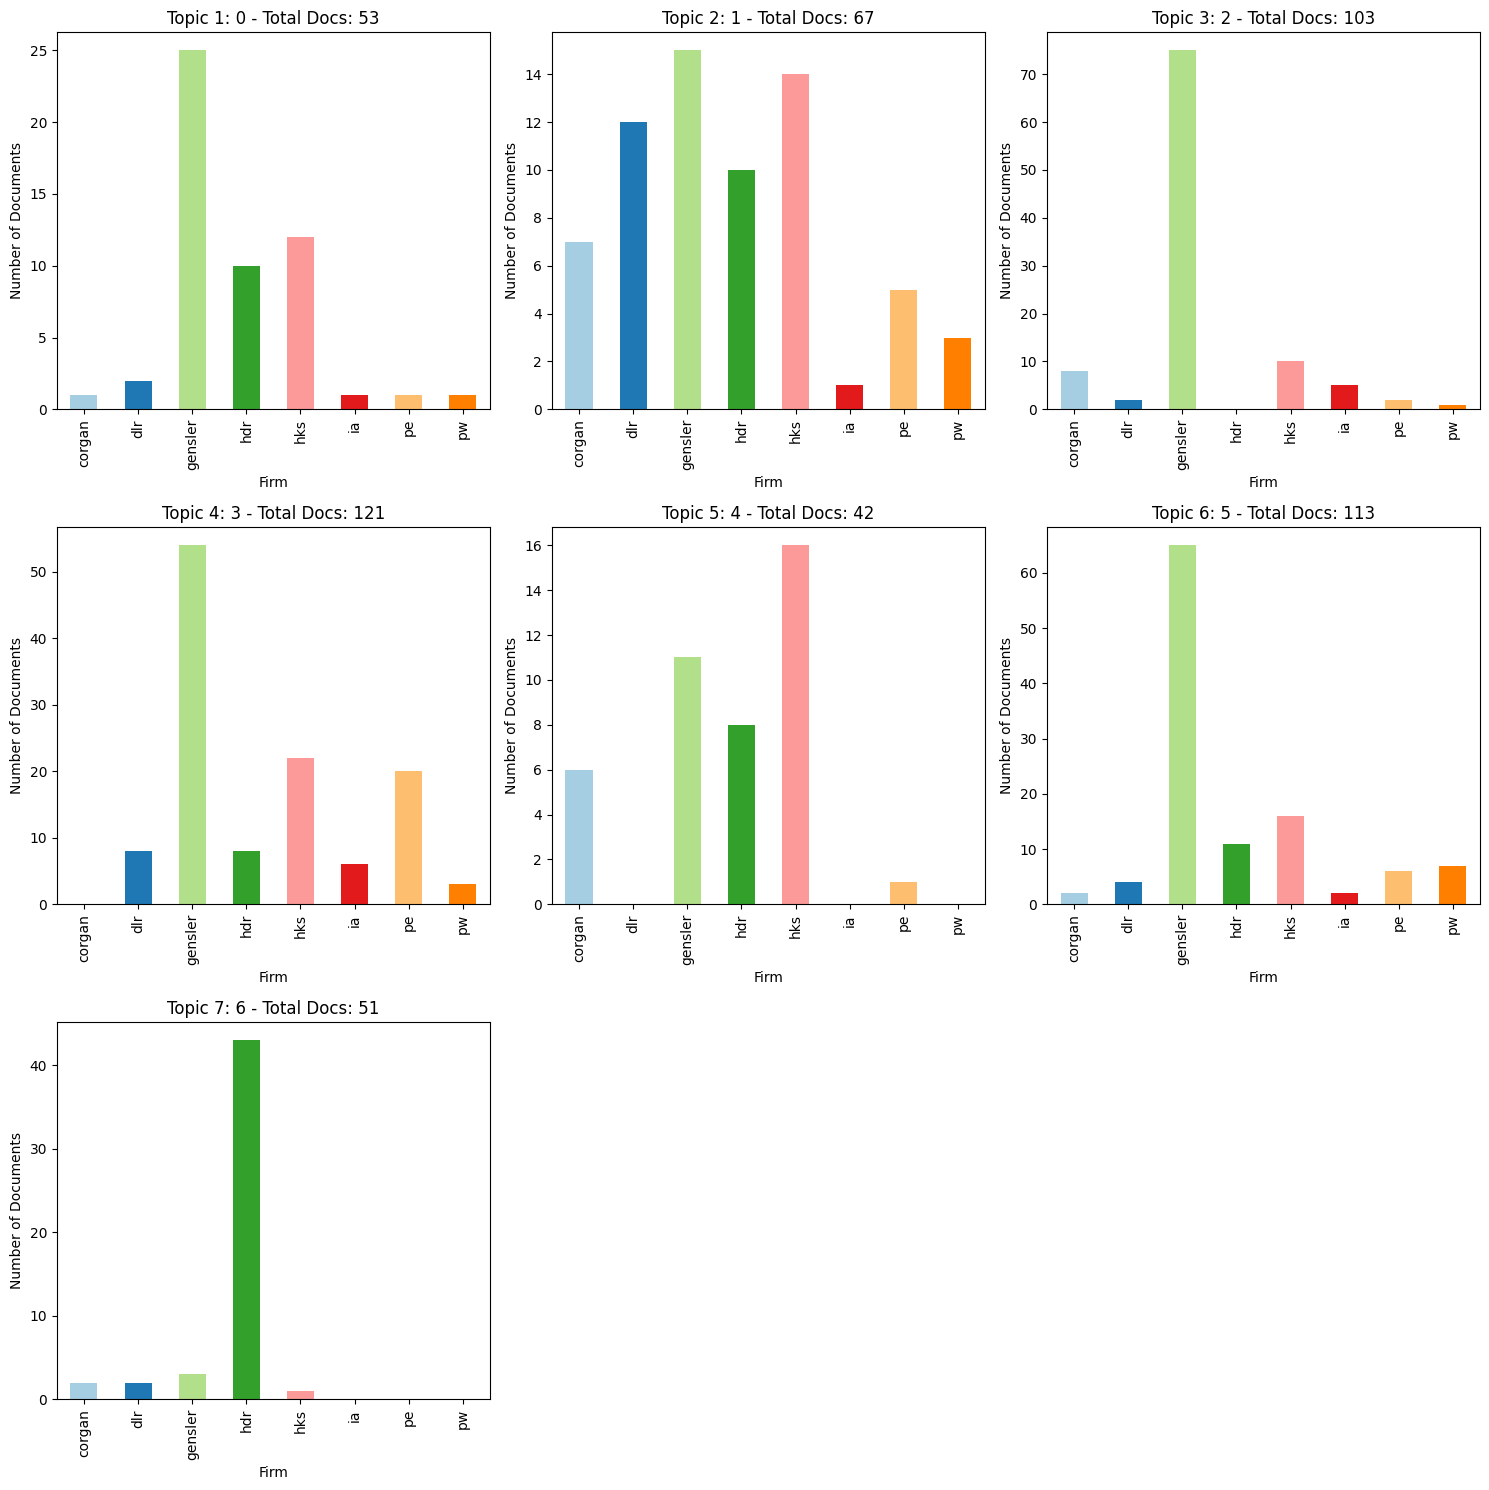

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is loaded and structured as needed

# Count the number of documents per Topic for each Firm
topic_firm_distribution = df.groupby(['Topic', 'Company_names']).size().unstack(fill_value=0)

# Total references per topic
topic_total_references = df.groupby('Topic').size()

# Plotting the results for each topic
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))  # Adjust the figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plotting only the number of topics, leaving the last two as empty if there are exactly 7 topics
for i, (topic, data) in enumerate(topic_firm_distribution.iterrows()):
    ax = axes[i]
    data.plot(kind='bar', ax=ax, title=f'Topic {i+1}: {topic} - Total Docs: {topic_total_references[topic]}', color=plt.cm.Paired(np.arange(len(data))))
    ax.set_ylabel('Number of Documents')
    ax.set_xlabel('Firm')

# If you have fewer than 9 topics (specifically 7), you need to hide the remaining axes
for j in range(len(topic_total_references), 9):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# Output the results to use in text
for topic, total_refs in topic_total_references.items():
    top_firms = topic_firm_distribution.loc[topic].nlargest(2)
    least_firms = topic_firm_distribution.loc[topic].nsmallest(2)
    print(f"Topic: {topic}\nTotal References: {total_refs}\nTop Contributors: {top_firms}\nLeast Contributors: {least_firms}\n")



NameError: name 'topic_total_references' is not defined